In [2]:
import numpy as np
import tensorflow as tf

from tensorflow.compat.v1.keras.backend import set_session

# We want our experiment to be reproducible
np.random.seed(42)
tf.compat.v1.set_random_seed(42)

# This setting allows Tensorflow to allocate GPU memory in runtime rather than at the session initialization.
config =tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
set_session(tf.compat.v1.Session(config=config))

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
train_data_dir = 'data/train'
test_data_dir = 'data/test'
validation_data_dir = 'data/validation'

img_height = 299
img_width = 299

# You may need to decrease batch size depending on your GPU capacity
batch_size = 16
epochs = 10

train_first_class = 2000
train_second_class = 2000

val_first_class = 1000
val_second_class = 1000

nb_train_samples = train_first_class + train_second_class
nb_validation_samples = val_first_class + val_second_class

In [4]:
from keras.layers import Input
from keras.applications import xception
from keras.preprocessing import image

input_tensor = Input(shape=(img_height,img_width,3))

base_model = xception.Xception(weights='imagenet',
                          include_top=False,
                          input_shape=(img_width, img_height, 3),
                          pooling='avg')

data_generator = image.ImageDataGenerator(rescale=1. / 255)

train_generator = data_generator.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode=None,
    shuffle=False)

bottleneck_features_train = base_model.predict(
        train_generator, 
        nb_train_samples // batch_size)

print('Prediction of the training set finished.')

np.save(open('bottleneck_features_train.npy', 'wb'),
            bottleneck_features_train)

validation_generator = data_generator.flow_from_directory(
    validation_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode=None,
    shuffle=False)

bottleneck_features_validation = base_model.predict(
        validation_generator, 
        nb_validation_samples // batch_size)

print('Prediction of the validation set finished.')

np.save(open('bottleneck_features_validation.npy', 'wb'),
            bottleneck_features_validation)

Found 4000 images belonging to 2 classes.
Prediction of the training set finished.
Found 2000 images belonging to 2 classes.
Prediction of the validation set finished.


In [5]:
train_data = np.load(open('bottleneck_features_train.npy', 'rb'))
train_labels = np.array(([0] * train_first_class) + ([1] * train_second_class))

validation_data = np.load(open('bottleneck_features_validation.npy', 'rb'))
validation_labels = np.array(
        [0] * (val_first_class) + [1] * (val_second_class))

In [6]:
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint
from keras.optimizers import SGD
from keras.layers import Dropout, Dense

model = Sequential()
    
model.add(Dense(256, activation='relu', input_shape=base_model.output_shape[1:]))
model.add(Dropout(0.5))

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))    

model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=SGD(lr=0.005),
              loss='binary_crossentropy',
              metrics=['acc'])

checkpointer = ModelCheckpoint(filepath='top-weights.hdf5', verbose=1, save_best_only=True)

history = model.fit(train_data,
                    train_labels,
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[checkpointer],
                    validation_data=(validation_data, validation_labels))

Epoch 1/10
250/250 [==============================] - 3s 9ms/step - loss: 0.5745 - acc: 0.7158 - val_loss: 0.1940 - val_acc: 0.9930

Epoch 00001: val_loss improved from inf to 0.19401, saving model to top-weights.hdf5
Epoch 2/10
250/250 [==============================] - 1s 5ms/step - loss: 0.2102 - acc: 0.9648 - val_loss: 0.0688 - val_acc: 0.9935

Epoch 00002: val_loss improved from 0.19401 to 0.06878, saving model to top-weights.hdf5
Epoch 3/10
250/250 [==============================] - 1s 5ms/step - loss: 0.1015 - acc: 0.9807 - val_loss: 0.0422 - val_acc: 0.9935

Epoch 00003: val_loss improved from 0.06878 to 0.04220, saving model to top-weights.hdf5
Epoch 4/10
250/250 [==============================] - 1s 5ms/step - loss: 0.0730 - acc: 0.9855 - val_loss: 0.0323 - val_acc: 0.9940

Epoch 00004: val_loss improved from 0.04220 to 0.03231, saving model to top-weights.hdf5
Epoch 5/10
250/250 [==============================] - 1s 5ms/step - loss: 0.0530 - acc: 0.9886 - val_loss: 0.0278 - 

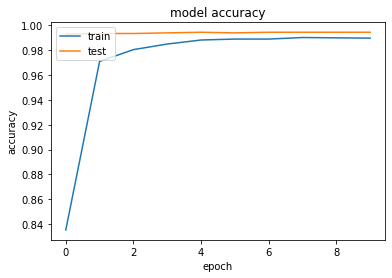

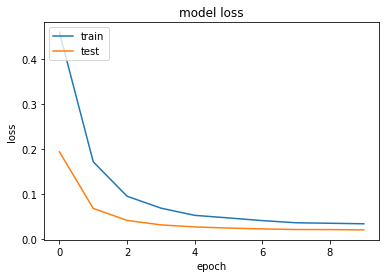

In [7]:
%matplotlib inline
from matplotlib import pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [8]:
from keras.models import Model

batch_size = 8
epochs = 5 

input_tensor = Input(shape=(img_height,img_width,3))

base_model = xception.Xception(weights='imagenet',
                                            include_top=False,
                                            input_shape=(img_width, img_height, 3),
                                            pooling='avg')

top_model = Sequential()
    
top_model.add(Dense(256, activation='relu', input_shape=base_model.output_shape[1:]))
top_model.add(Dropout(0.5))

top_model.add(Dense(128, activation='relu'))
top_model.add(Dropout(0.5))    

top_model.add(Dense(1, activation='sigmoid'))

top_model.load_weights('top-weights.hdf5')

model = Model(inputs=base_model.input, outputs=top_model(base_model.output))

model.compile(optimizer=SGD(lr=0.005, momentum=0.1, nesterov=True),
              loss='binary_crossentropy',
              metrics=['acc'])


checkpointer = ModelCheckpoint(filepath='weights.hdf5', verbose=1, save_best_only=True)

train_datagen = image.ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

test_datagen = image.ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='binary')

history = model.fit(train_generator,
                            steps_per_epoch=nb_train_samples // batch_size,
                            epochs=epochs,
                            validation_data=validation_generator,
                            validation_steps=nb_validation_samples // batch_size)

Found 4000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Epoch 1/2
2000/2000 [==============================] - 357s 176ms/step - loss: 0.3414 - acc: 0.8644 - val_loss: 0.0585 - val_acc: 0.9770
Epoch 2/2
2000/2000 [==============================] - 347s 173ms/step - loss: 0.0771 - acc: 0.9759 - val_loss: 0.0240 - val_acc: 0.9900


In [29]:
test_generator = data_generator.flow_from_directory(
    test_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False)

score = model.evaluate(test_generator)
print("Loss: ", score[0], "Accuracy: ", score[1])

Found 6000 images belonging to 2 classes.
3000/3000 [==============================] - 94s 31ms/step - loss: 0.0296 - acc: 0.9898
[0.02963925153017044, 0.9898333549499512]
